#  Analysis of Q294K titrations

In [1]:
import sys
import numpy as np
import pandas as pd
import pystan
import altair as alt
sys.path.insert(0, '../../')
import mut.thermo
import mut.stats
import mut.bayes
import mut.viz
colors = mut.viz.color_selector('mut')
pboc = mut.viz.altair_config()
alt.renderers.enable('notebook')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


RendererRegistry.enable('notebook')

##  Sanity check the data

In [2]:
# Load the data
data = pd.read_csv('../../data/csv/compiled_data.csv')
data = data[data['mutant'] == 'Q294K']
data = data[data['fold_change'] > 0]

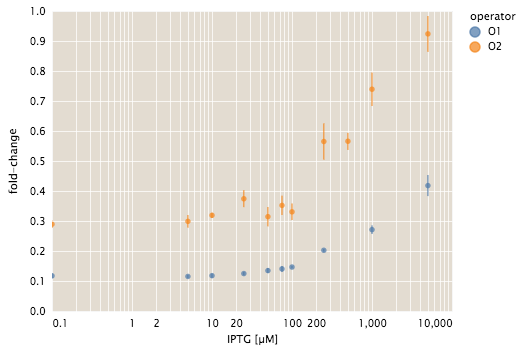

In [3]:
# group by operator and compute the statistics
# grouped = pd.DataFrame(data.groupby(['operator', 'IPTGuM']).apply(mut.stats.compute_mean_sem)).reset_index()
crp = data[data['IPTGuM'] != 0]

# Plot
means = alt.Chart(crp).mark_circle().transform_aggregate(
             mean_fc='mean(fold_change)',
             mean_c='mean(IPTGuM)',
             groupby=['IPTGuM', 'operator']).encode(
             x=alt.X('mean_c:Q', title='IPTG [µM]', scale={'type': 'log'}),
             y=alt.Y('mean_fc:Q', title='fold-change'),
             color='operator').interactive()
errs = alt.Chart(crp).mark_rule().transform_aggregate(
             mean_fc='mean(fold_change)',
             mean_c='mean(IPTGuM)',
             stdev = 'stdev(fold_change)',
             groupby=['IPTGuM', 'operator']).transform_calculate(
             lower='datum.mean_fc-datum.stdev',
             upper='datum.mean_fc+datum.stdev').encode(
             x=alt.X('mean_c:Q', title='IPTG [µM]', scale={'type': 'log'}),
             y=alt.Y('lower:Q', title='fold-change'),
             y2=alt.Y('upper:Q', title='fold-change'), 
             color='operator').interactive()

alt.layer(means + errs, config=pboc)


##  Fit the $\Delta\varepsilon_{AI}$ to O1

In [4]:
# Load the model.
allo_model = pystan.StanModel('../stan/allosteric_energy.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_77654e917c209fa9a235a319946cc0e9 NOW.


In file included from /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpvp8wed02/stanfit4anon_model_77654e917c209fa9a235a319946cc0e9_3519428777402138281.cpp:599:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1816:
/anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
/var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpvp8wed02/stanfit4anon_model_77654e917c209fa9a235a319946cc0e9_3519428777402138281.cpp:9155:30: warning: comparison of integers of different signs: 'Py_ssize_t' (aka 'long') and 'std::_

In [5]:
# Assemble the data dictionary and sample.
epAI_data = data[(data['operator'] == 'O1') & (data['IPTGuM']==0)]
data_dict = {'N':len(epAI_data), 'R':epAI_data['repressors'], 'epR':-15.3,
             'Nns':4.6E6, 'fc':epAI_data['fold_change']}
allo_samples = allo_model.sampling(data_dict, iter=5000, chains=4)
allo_df = mut.bayes.chains_to_dataframe(allo_samples, varnames=['ep_ai'])
allo_stats = mut.stats.compute_statistics(allo_df)

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


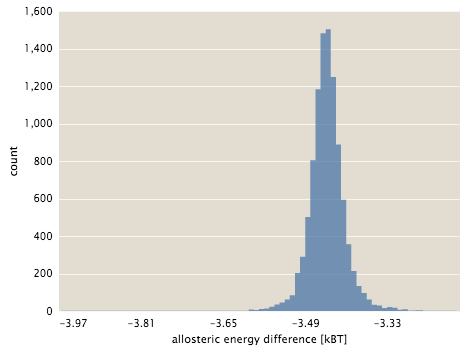

In [6]:
# Look at the distributions of samples. 
alt.data_transformers.enable('json')
alt.Chart(allo_df, config=pboc).mark_area(opacity=0.75, interpolate='step').encode(
    x=alt.X('ep_ai:Q',title='allosteric energy difference [kBT]', 
            bin=alt.Bin(maxbins=100)), 
    y=alt.Y('count(ep_ai)', title='count'))

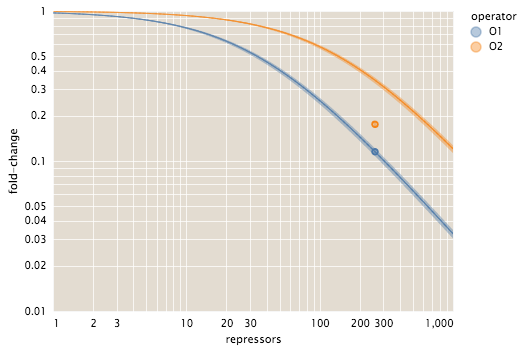

In [7]:
# Compute the expected leakiness
rep_range = np.logspace(0, 3, 500)
ops = {'O1':-15.3, 'O2':-13.9}
dfs = []
for i, o in enumerate(ops.keys()): 
    leak_mode = mut.thermo.SimpleRepression(rep_range, ops[o], 
               ep_ai=allo_stats[allo_stats['parameter']=='ep_ai']['mode'].values[0],
               effector_conc=0, ka=1, ki=1).fold_change()
    leak_min = mut.thermo.SimpleRepression(rep_range, ops[o], 
               ep_ai=allo_stats[allo_stats['parameter']=='ep_ai']['hpd_min'].values[0],
               effector_conc=0, ka=1, ki=1).fold_change() 
    leak_max = mut.thermo.SimpleRepression(rep_range, ops[o], 
               ep_ai=allo_stats[allo_stats['parameter']=='ep_ai']['hpd_max'].values[0],
               effector_conc=0, ka=1, ki=1).fold_change()
    _df = pd.DataFrame(np.array([leak_mode, leak_min, leak_max, rep_range]).T, 
                       columns=['mode', 'min', 'max', 'repressors'])
    _df['operator'] = o
    dfs.append(_df)
    
leak_df = pd.concat(dfs, axis=0)

# Plot the leakiness and credible regions.
modes = alt.Chart(leak_df).mark_line(strokeWidth=1).encode(
    x=alt.X('repressors', scale={'type':'log'}, title='repressors'),
    y=alt.Y('mode', title='fold-change', scale={'type': 'log'}),
    color='operator')
ci = alt.Chart(leak_df).mark_area(opacity=0.4).encode( 
    x =alt.X('repressors:Q', scale={'type':'log'}, title='repressors'),
    y=alt.Y('min:Q', title='fold-change', scale={'type':'log'}),
    y2='max:Q', color='operator').interactive()
points = alt.Chart(data[data['IPTGuM']==0]).mark_point().encode(
        x=alt.X('mean(repressors)', scale={'type':'log'}, title='repressors'),
        y=alt.Y('mean(fold_change)', scale={'type':'log'}, title='fold-change'),
        color='operator')
errs = alt.Chart(data[data['IPTGuM']==0]).mark_rule().transform_aggregate(
             mean_fc='mean(fold_change)',
             mean_R='mean(repressors)',
             stderr = 'stderr(fold_change)',
             groupby=['operator']).transform_calculate(
             lower='datum.mean_fc-datum.stderr',
             upper='datum.mean_fc+datum.stderr').encode(
             x=alt.X('mean_R:Q', title='repressors', scale={'type': 'log'}),
             y=alt.Y('lower:Q', title='fold-change', scale={'type': 'log'}),
             y2='upper:Q', 
             color='operator').interactive()
alt.layer(modes + ci + points + errs, config=pboc)

##  Fit Ka/Ki to Q294K O1

In [8]:
kaki_model = pystan.StanModel('../stan/KaKi_fitting.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ce9a73f93720043aca313843fce095a0 NOW.


In file included from /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpwc80kgzb/stanfit4anon_model_ce9a73f93720043aca313843fce095a0_4122443569833770005.cpp:599:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1816:
/anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
/var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpwc80kgzb/stanfit4anon_model_ce9a73f93720043aca313843fce095a0_4122443569833770005.cpp:9155:30: warning: comparison of integers of different signs: 'Py_ssize_t' (aka 'long') and 'std::_

In [9]:
O1_data = data[data['operator']=='O1']
data_dict = {'N':len(O1_data), 'R':O1_data['repressors'], 'Nns':4.6E6, 'c':O1_data['IPTGuM'],
             'epR':-15.3, 'ep_ai':allo_stats[allo_stats['parameter']=='ep_ai']['mode'].values[0],
              'n_sites':2, 'fc':O1_data['fold_change']}
kaki_samples = kaki_model.sampling(data_dict, iter=5000, chains=4)
kaki_df = mut.bayes.chains_to_dataframe(kaki_samples, varnames=['ka', 'ki'])
kaki_stats = mut.stats.compute_statistics(kaki_df)

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


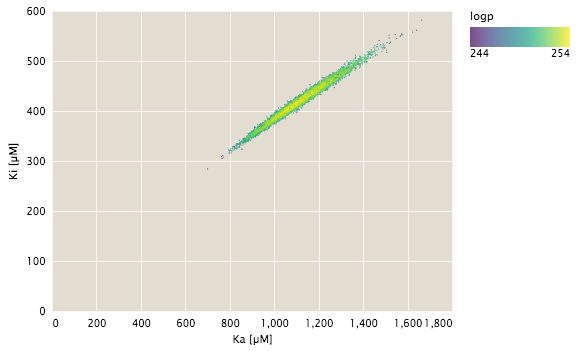

In [10]:
alt.Chart(kaki_df, config=pboc).mark_circle(size=1.5).encode(
alt.X('ka:Q', title='Ka [µM]'),
alt.Y('ki:Q', title='Ki [µM]'),
alt.Color('logp:Q', scale=alt.Scale(scheme='viridis'))).interactive()

In [11]:
# Plot the best fit to the data. 
c_range = np.logspace(-2, 4, 500)
dfs = []
for i, o in enumerate(ops.keys()):
    mode = mut.thermo.SimpleRepression(260, ops[o], effector_conc=c_range,
              ka=kaki_stats[kaki_stats['parameter']=='ka']['mode'].values[0],
              ki=kaki_stats[kaki_stats['parameter']=='ki']['mode'].values[0],
              ep_ai=allo_stats[allo_stats['parameter']=='ep_ai']['mode'].values[0]).fold_change()
    _df = pd.DataFrame(np.array([c_range, mode]).T, columns=['IPTGuM', 'mode'])
    _df['operator'] = o
    dfs.append(_df)
fit_df = pd.concat(dfs)

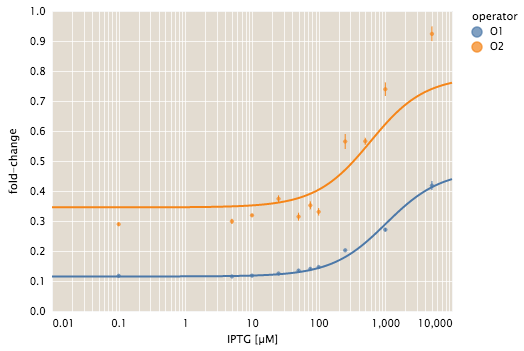

In [12]:
# Plot the fits.
fits = alt.Chart(fit_df).mark_line().encode(
    alt.X('IPTGuM', title='IPTG [µM]', scale={'type':'log'}),
    alt.Y('mode', title='fold-change'),
    color='operator')
points = alt.Chart(crp).mark_circle(size=20).transform_aggregate(
    mean_fc='mean(fold_change):Q', mean_c='mean(IPTGuM):Q',
    groupby=['IPTGuM', 'operator']).encode(
    alt.X('mean_c:Q', title='IPTG [µM]', scale={'type':'log'}),
    alt.Y('mean_fc:Q', title='fold-change'),
    color='operator')
errors = alt.Chart(crp).mark_rule().transform_aggregate(
    mean_fc='mean(fold_change):Q', mean_c='mean(IPTGuM):Q',
    sem_fc = 'stderr(fold_change):Q',
    groupby=['IPTGuM', 'operator']).transform_calculate(
    lower='datum.mean_fc - datum.sem_fc',
    upper='datum.mean_fc + datum.sem_fc').encode(
    x=alt.X('mean_c:Q', title='IPTG [µM]', scale={'type':'log'}),
    y=alt.Y('lower:Q', title='fold-change'),
    y2='upper:Q', color='operator')
alt.layer(fits + points + errors, config=pboc)